In [1]:
autosave 0

# Linear inversion examples

## Preliminary steps

### Importing necessary libraries

In [ ]:
import genericSolver

In [ ]:
#Adding library modules to PYTHONPATH
import sys
#sys.path.append("../python")
import numpy as np
#Inversion library-related modules
import genericSolver.pyVector as Vec
import genericSolver.pyOperator as Op
from genericSolver.pyNpOperator import MatrixOp
from genericSolver.pyLinearSolver import LCGsolver as LCG
from genericSolver.pyLinearSolver import SymLCGsolver
import genericSolver.pyProblem as Prblm
from genericSolver.pyStopper import BasicStopper as Stopper
#Plotting library
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


## Instantiation of vectors and operator

For testing the library we will be using a discretized version of the following operator:
\begin{align}
y = \frac{d^2f(x)}{dx^2},
\end{align}
in which we simply compute the second-order derivative of a function $f(x)$. 

In [3]:
N=200 #Number of points of the function f(x)
dx=1/(N) #Sampling of the function
D2 = np.matrix(np.zeros((N,N),dtype=np.float64)) #Matrix containing the discretization of the derivative operator
#The stencil used is simply: (f(ix-1)-2f(ix)+f(ix+1))/(dx*dx)
np.fill_diagonal(D2, -2/(dx*dx))
np.fill_diagonal(D2[1:], 1/(dx*dx))
np.fill_diagonal(D2[:,1:], 1/(dx*dx))
f = Vec.vectorIC(np.zeros((N,1),dtype=np.float64)) #Initializing numpy-based vector for f(x)
y = Vec.vectorIC(np.zeros((N,1),dtype=np.float64)) #Initializing numpy-based vector for y
D2Op = MatrixOp(D2,f,y)

Before we set any inversion problem, we study some of the properties of the constructed operator Deriv2Op.

In [4]:
#Verifying operator adjointness through dot-product test
D2Op.dotTest(verbose=True)
#Computing maximum and minimum eigenvalues of the operator using the power iteration method and 
#compare them against the ones computed using numpy
egsOp=D2Op.powerMethod(verbose=False,eval_min=True,tol=1e-300)
egsNp,_=np.linalg.eig(D2)
egsNp = egsNp[egsNp.argsort()[::-1]] #Sorting the eigenvalues
print("\nMaximum eigenvalue: %s (Power method), %s (NUMPY)"%(egsOp[0],egsNp[-1]))
print("Minimum eigenvalue: %s (Power method), %s (NUMPY)"%(egsOp[1],egsNp[0]))

Dot-product test of forward and adjoint operators
-------------------------------------------------
Applying forward operator add=False
 Runs in: 0.000102996826171875 seconds
Applying adjoint operator add=False
 Runs in: 6.413459777832031e-05 seconds
Dot products add=False: domain=4.822865e+05 range=4.822865e+05 
Absolute error: 5.820766e-11
Relative error: 1.206910e-16 

Applying forward operator add=True
 Runs in: 3.719329833984375e-05 seconds
Applying adjoint operator add=True
 Runs in: 3.790855407714844e-05 seconds
Dot products add=True: domain=9.645730e+05 range=9.645730e+05 
Absolute error: 1.164153e-10
Relative error: 1.206910e-16 

-------------------------------------------------

Maximum eigenvalue: -159990.2285548014 (Power method), -159990.2285552524 (NUMPY)
Minimum eigenvalue: -9.771445150487125 (Power method), -9.771444747783526 (NUMPY)


We can see that the matrix is negative definite. The small mismatch in the estimated eigenvalues is due to the dependence of the power method on the initial random eigenvector.

## Inversion tests

We will now focus our attention on inverting a function knowning its second-order derivative. In this case we will assume that $y$ is constant and equal to $1$. Therefore, we expect to obtain a parabola with positive curvature. Given the chosen boundary conditions we know that the matrix is invertible since all eigenvalues have the same sign and are different then zero.
We will solve the following objective functions using linear conjugate-gradient methods:
\begin{equation*}
\phi_1(\mathbf{f}) = \frac{1}{2}\|D_2\mathbf{f}-\mathbf{y}\|_2^2
\end{equation*}
and
\begin{equation*}
\phi_2(\mathbf{f}) = \frac{1}{2}\mathbf{f}^T D_2 \mathbf{f} - \mathbf{f}^{T} \mathbf{y},
\end{equation*}
where $D_2$ represents the discretized second-order derivative operator, while $\mathbf{f}$ and $\mathbf{y}$ are the discretized representations of $f$ and $y$, respectively.

In [20]:
y.set(1.0) # y = 1
#Note that f = 0
Phi1 = Prblm.ProblemL2Linear(f.clone(),y,D2Op)
Phi2 = Prblm.ProblemLinearSymmetric(f.clone(),y,D2Op)

### Instantiation of solver objects

First, we create two different solver object for solving the two inversion problem stated above.

In [21]:
#Create stopping criteria and related object
niter = 2000
Stop  = Stopper(niter=niter)
#Create LCG solver
LCGsolver = LCG(Stop)
LCGsolver.setDefaults(save_obj=True) #Saving objective function within the solver
#Create LCG solver for symmetric systems
SLCG = SymLCGsolver(Stop)
SLCG.setDefaults(save_obj=True,save_model=True)

Secondly, we run the solvers to minimize the objective functions previously defined.

In [22]:
LCGsolver.run(Phi1,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /tmp/restart_2020-07-23T11-51-04.289951/
	Modeling Operator:		MatrixOp
##########################################################################################

iter = 0000, obj = 1.00000e+02, resnorm = 1.41e+01, gradnorm = 5.66e+04, feval = 2
iter = 0001, obj = 9.98000e+01, resnorm = 1.41e+01, gradnorm = 4.66e+04, feval = 4
iter = 0002, obj = 9.96483e+01, resnorm = 1.41e+01, gradnorm = 4.20e+04, feval = 6
iter = 0003, obj = 9.95208e+01, resnorm = 1.41e+01, gradnorm = 3.90e+04, feval = 8
iter = 0004, obj = 9.94086e+01, resnorm = 1.41e+01, gradnorm = 3.69e+04, feval = 10
iter = 0005, obj = 9.93072e+01, resnorm = 1.41e+01, gradnorm = 3.52e+04, feval = 12
iter = 0006, obj = 9.92139e+01, resnorm = 1.41e+01, gradnorm = 3.39e+04, feval = 14
iter = 0007, obj = 9.91271e+01, resnorm = 1.41e+01, gradnorm = 3.28e+04, feval = 16
iter = 0008, obj = 9.90

In [19]:
SLCG.run(Phi2,verbose=True)

##########################################################################################

iter = 0000, obj = 8.45875e+00, resnorm = 3.41e-16, feval = 203
iter = 0001, obj = 8.45875e+00, resnorm = 2.07e-16, feval = 205
Objective function variation not monotonic, will terminate solver:obj_old=8.45875e+00 obj_cur=8.45875e+00 obj_new=8.45875e+00
##########################################################################################
LINEAR CONJUGATE GRADIENT SOLVER FOR SYMMETRIC MATRIX end
##########################################################################################



Finally, we can look at the results.

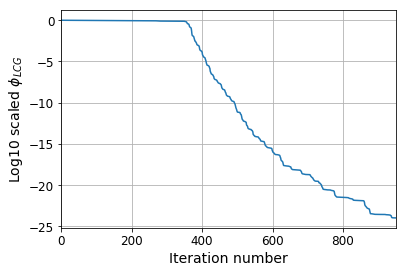

In [9]:
%matplotlib inline
plt.plot(np.log10(LCGsolver.obj/LCGsolver.obj[0]))
# plt.title("LCG convergence")
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Log10 scaled $\phi_{LCG}$",fontsize=14)
ax = plt.gca() 
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.savefig('D2-LCG.pdf', format='pdf', dpi=300, bbox_inches='tight')

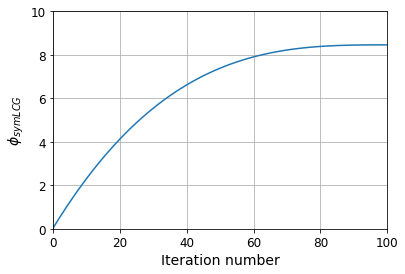

In [10]:
%matplotlib inline
plt.plot(SLCG.obj)
# plt.title("Symmetric LCG convergence")
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("$\phi_{symLCG}$",fontsize=14)
ax = plt.gca() 
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([0,10])
plt.xlim([0,100])
plt.savefig('D2-symLCG.pdf', format='pdf', dpi=300, bbox_inches='tight')

Also, let's compare the two inverted functions with the analytical solution.
To find the solution for the continuous case we need three conditions:
\begin{equation}
\frac{d^2f(x)}{dx^2}=1,\\
f(x=0)=0,\\
f(x=x_f)=0.
\end{equation}
$x = 0$ and $x = x_f$ are not sampled and lay outside of the interval $\mathbf{x}$.

In [11]:
X = np.linspace(dx,N*dx,N)
alpha = 0.5
beta  = -(X[-1]+dx)*0.5
gamma = 0.0
f_an  = alpha * X * X + beta * X + gamma

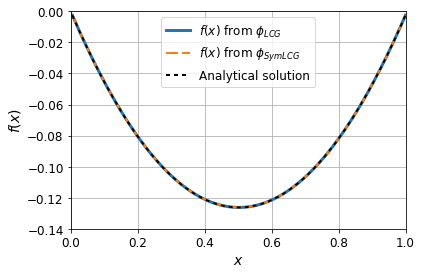

In [12]:
_ = plt.plot(X,Phi1.model.getNdArray(),linewidth=3,label="$f(x)$ from $\phi_{LCG}$")
_ = plt.plot(X,Phi2.model.getNdArray(),linewidth=2,dashes=[6, 2],label="$f(x)$ from $\phi_{SymLCG}$")
_ = plt.plot(X,f_an,'k',linewidth=2,dashes=[2, 2],label="Analytical solution")
ax = plt.gca() 
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend()
plt.grid()
plt.xlabel(r"$x$",fontsize=14)
plt.ylabel("$f(x)$",fontsize=14)
plt.ylim([-0.14,0])
plt.xlim([0,1.0])
# _ = plt.title("Inverted functions")
plt.savefig('D2-func.pdf', format='pdf', dpi=300, bbox_inches='tight')

Now, let's try to solve both inversions using the inverse of $D_2$ as a preconditioner

In [13]:
PrecOp = MatrixOp(np.linalg.inv(D2),f,y) # P = [D_2]^-1
Phi1Prec = Prblm.ProblemL2Linear(f.clone(),y,D2Op,prec=Op.ChainOperator(PrecOp,PrecOp)) #In this line we chain [D_2]^-1 twice
Phi2Prec = Prblm.ProblemLinearSymmetric(f.clone(),y,D2Op,prec=PrecOp)

In [14]:
LCGsolver.setDefaults() # Re-setting default solver values
SLCG.setDefaults() # Re-setting default solver values

In [15]:
LCGsolver.run(Phi1Prec,verbose=True)

##########################################################################################
				PRECONDITIONED LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /tmp/restart_2020-07-23T11-48-21.401250/
	Modeling Operator:		MatrixOp
##########################################################################################

iter = 0000, obj = 1.00000e+02, resnorm = 1.41e+01, gradnorm = 5.66e+04, feval = 2
iter = 0001, obj = 1.60713e-22, resnorm = 1.79e-11, gradnorm = 2.33e-06, feval = 4
iter = 0002, obj = 3.45248e-46, resnorm = 2.63e-23, gradnorm = 5.63e-19, feval = 6
Objective function didn't reduce, will terminate solver:
	obj_new = 3.45248e-46	obj_cur = 3.45248e-46
##########################################################################################
				PRECONDITIONED LINEAR CONJUGATE GRADIENT SOLVER end
##########################################################################################



In [16]:
SLCG.run(Phi2Prec,verbose=True)

##########################################################################################

iter = 0000, obj = 0.00000e+00, resnorm = 1.41e+01, feval = 1
iter = 0001, obj = 8.45875e+00, resnorm = 1.64e-11, feval = 3
Objective function variation not monotonic, will terminate solver:obj_old=0.00000e+00 obj_cur=8.45875e+00 obj_new=8.45875e+00
##########################################################################################
PRECONDITIONED LINEAR CONJUGATE GRADIENT SOLVER FOR SYMMETRIC MATRIX end
##########################################################################################



As expected, we converge to the global minimum in effectively one iteration.